In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import time

class Timer:
    """A simple context manager for timing code blocks."""
    def __init__(self, timings_dict, key):
        self.timings = timings_dict
        self.key = key
        self.start_time = None

    def __enter__(self):
        self.start_time = time.time()
        print(f"[{self.key}] starting...")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        elapsed = time.time() - self.start_time
        self.timings[self.key] = elapsed
        print(f"[{self.key}] finished in {elapsed:.2f} seconds.")

def report_timings(timings):
    """Prints a summary of the timings."""
    print("\n--- Timing Report ---")
    total_time = 0
    for key, value in timings.items():
        print(f"  - {key}: {value:.2f} seconds")
        total_time += value
    print("---------------------")
    print(f"  Total Elapsed Time: {total_time:.2f} seconds")

def save_report(report_path, config, model_summary, history, final_accuracy, timings):
    """Saves a detailed report of the training session to a text file."""
    print(f"\n--- Saving Training Report to {report_path} ---")
    with open(report_path, 'w') as f:
        f.write("="*60 + "\n")
        f.write("           TRAINING SESSION REPORT\n")
        f.write("="*60 + "\n\n")
        
        # --- 1. Configuration ---
        f.write("--- 1. Training Configuration ---\n")
        for key, value in config.items():
            f.write(f"  - {key}: {value}\n")
        f.write("\n")

        # --- 2. Model Architecture ---
        f.write("--- 2. Model Architecture ---\n")
        f.write(model_summary + "\n\n")

        # --- 3. Training History ---
        f.write("--- 3. Training History (Epoch-wise) ---\n")
        epochs = range(1, len(history['train_loss']) + 1)
        header = f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc (%)':<15} | {'Val Acc (%)':<13}\n"
        f.write(header)
        f.write("-" * len(header) + "\n")
        for i, epoch in enumerate(epochs):
            loss = history['train_loss'][i]
            train_acc = history['train_acc'][i]
            val_acc = history['val_acc'][i]
            f.write(f"{epoch:<7} | {loss:<12.4f} | {train_acc:<15.2f} | {val_acc:<13.2f}\n")
        f.write("\n")

        # --- 4. Final Performance ---
        f.write("--- 4. Final Performance on Test Set ---\n")
        f.write(f"  - Accuracy: {final_accuracy:.2f} %\n\n")

        # --- 5. Timing Report ---
        f.write("--- 5. Timing Report ---\n")
        total_time = 0
        for key, value in timings.items():
            f.write(f"  - {key}: {value:.2f} seconds\n")
            total_time += value
        f.write("---------------------\n")
        f.write(f"  Total Elapsed Time: {total_time:.2f} seconds\n")
    
    print("Report saved successfully.")

class DynamicCNN(nn.Module):
    """
    A dynamically configurable Convolutional Neural Network (CNN).
    The user can specify the architecture including convolutional layers,
    pooling layers, and fully connected layers.
    """
    def __init__(self, input_channels, num_classes, conv_layers_config, fc_layers_config):
        """
        Initializes the DynamicCNN model.

        Args:
            input_channels (int): Number of input channels (e.g., 3 for RGB images).
            num_classes (int): Number of output classes.
            conv_layers_config (list of tuples): Each tuple defines a convolutional block.
                Format: (out_channels, kernel_size, stride, padding, use_pooling)
                'use_pooling' is a boolean to add a MaxPool2d layer after the conv layer.
            fc_layers_config (list of int): A list where each integer is the number of
                neurons in a fully connected layer.
        """
        super(DynamicCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()

        in_channels = input_channels

        # Create convolutional layers dynamically
        for out_channels, kernel_size, stride, padding, use_pooling in conv_layers_config:
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            )
            if use_pooling:
                self.pool_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                self.pool_layers.append(nn.Identity()) # Placeholder if no pooling
            in_channels = out_channels

        # To determine the input size of the first fully connected layer,
        # we need to do a forward pass with a dummy tensor.
        # This is a common practice when the architecture is dynamic.
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 64, 64) # Assuming 64x64 images
            dummy_output = self._forward_conv(dummy_input)
            flattened_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

        in_features = flattened_size

        # Create fully connected layers dynamically
        for out_features in fc_layers_config:
            self.fc_layers.append(nn.Linear(in_features, out_features))
            in_features = out_features
        
        # Output layer
        self.output_layer = nn.Linear(in_features, num_classes)

    def _forward_conv(self, x):
        """Helper function to forward through conv layers only."""
        for conv, pool in zip(self.conv_layers, self.pool_layers):
            x = torch.relu(conv(x))
            x = pool(x)
        return x

    def forward(self, x):
        """
        Defines the forward pass of the model.
        """
        x = self._forward_conv(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Forward pass through fully connected layers
        for fc_layer in self.fc_layers:
            x = torch.relu(fc_layer(x))
            
        x = self.output_layer(x)
        return x

def evaluate_model(model, loader, device='cpu'):
    """
    Evaluates the model's accuracy on a given dataset.
    Used for validation and training accuracy checks.
    """
    model.to(device)
    model.eval() # Set the model to evaluation mode
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    """
    Trains the PyTorch model and tracks history for plotting.
    """
    model.to(device)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    total_training_time = 0
    print("Starting training...")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train() # Set the model to training mode
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        
        # Evaluate on training and validation set after each epoch
        train_acc = evaluate_model(model, train_loader, device)
        val_acc = evaluate_model(model, val_loader, device)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        epoch_duration = time.time() - epoch_start_time
        total_training_time += epoch_duration
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}% -- Took {epoch_duration:.2f}s')
            
    print(f"Finished training. Total training time: {total_training_time:.2f}s")
    return history, total_training_time

def test_model(model, test_loader, device='cpu'):
    """
    Tests the PyTorch model.
    """
    model.to(device)
    model.eval() # Set the model to evaluation mode
    
    correct = 0
    total = 0
    
    print("Starting testing...")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
    return accuracy

def plot_results(history):
    """
    Plots training and validation metrics using matplotlib.
    """
    print("\n--- Plotting Results ---")
    
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print("matplotlib not found. Please install it ('pip install matplotlib') to plot results.")
        return

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'o-', label='Training Accuracy', color='b')
    plt.plot(epochs, history['val_acc'], 'o-', label='Validation Accuracy', color='r')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'o-', label='Training Loss', color='g')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    print("Results plot saved as 'training_results.png'")
    # You can uncomment the line below to display the plot directly
    # plt.show()

def save_model(model, path="cnn_model.pth"):
    """
    Saves the trained model's state dictionary.
    Handles models wrapped in nn.DataParallel.
    """
    print(f"Saving model to {path}...")
    # If the model is wrapped in DataParallel, save the underlying model's state_dict
    if isinstance(model, nn.DataParallel):
        torch.save(model.module.state_dict(), path)
    else:
        torch.save(model.state_dict(), path)
    print("Model saved.")

def load_model(model_class, path, *args, **kwargs):
    """
    Loads a model's state dictionary from a file.
    Args:
        model_class: The class of the model to be instantiated.
        path (str): The path to the saved model file.
        *args, **kwargs: Arguments needed to instantiate the model class.
    """
    print(f"Loading model from {path}...")
    model = model_class(*args, **kwargs)
    model.load_state_dict(torch.load(path))
    print("Model loaded.")
    return model

def analyze_dataset(loader, dataset_name="Training"):
    """
    Performs and prints a statistical analysis on the dataset from a DataLoader.
    Calculates class distribution, image dimensions, and pixel value statistics.

    Args:
        loader (DataLoader): The DataLoader for the dataset to analyze.
        dataset_name (str): Name of the dataset (e.g., "Training", "Testing").
    """
    print(f"\n--- Analyzing {dataset_name} Dataset ---")

    if not hasattr(loader, 'dataset'):
        print("DataLoader does not have a 'dataset' attribute.")
        return

    dataset = loader.dataset
    
    # Handle datasets wrapped in torch.utils.data.Subset (from random_split)
    if isinstance(dataset, torch.utils.data.Subset):
        # Get labels and data from the original dataset using subset indices
        labels = [dataset.dataset.tensors[1][i] for i in dataset.indices]
        data_tensor = torch.stack([dataset.dataset.tensors[0][i] for i in dataset.indices])
        labels_tensor = torch.tensor(labels)
    elif isinstance(dataset, TensorDataset):
        # Handle regular TensorDataset
        data_tensor = dataset.tensors[0]
        labels_tensor = dataset.tensors[1]
    else:
        print(f"Dataset type {type(dataset).__name__} is not supported for analysis.")
        return

    if len(labels_tensor) == 0:
        print("No labels found to analyze.")
        return

    # 1. Class Distribution
    print("Class Distribution:")
    unique_classes, counts = torch.unique(labels_tensor, return_counts=True)
    class_dist = dict(zip(unique_classes.tolist(), counts.tolist()))
    
    for cls in sorted(class_dist.keys()):
        percentage = (class_dist[cls] / len(labels_tensor)) * 100
        print(f"  Class {cls}: {class_dist[cls]} samples ({percentage:.2f}%)")

    # 2. General Metrics
    num_samples = data_tensor.shape[0]
    print(f"\nTotal Samples: {num_samples}")

    if data_tensor.dim() == 4:  # Expected format: (N, C, H, W)
        num_channels = data_tensor.shape[1]
        height = data_tensor.shape[2]
        width = data_tensor.shape[3]
        print(f"Image Dimensions: {height}x{width}")
        print(f"Number of Channels: {num_channels}")

        # 3. Mean and Standard Deviation of pixel values per channel
        # This is useful for data normalization
        print("\nPixel Value Statistics (per channel):")
        # Reshape to (N*H*W, C) to calculate stats per channel easily
        pixels = data_tensor.permute(0, 2, 3, 1).reshape(-1, num_channels)
        mean = pixels.mean(axis=0)
        std = pixels.std(axis=0)

        for c in range(num_channels):
            print(f"  Channel {c}: Mean={mean[c]:.4f}, Std Dev={std[c]:.4f}")
    
    print("--------------------------------------")


def create_dummy_dataset(num_samples=1000, img_size=(64, 64), num_classes=10, channels=3):
    """
    Creates a dummy dataset for demonstration purposes.
    Returns:
        (DataLoader, DataLoader): train_loader, test_loader
    """
    print("Creating a dummy dataset...")
    # Generate random images and labels
    data = np.random.rand(num_samples, channels, img_size[0], img_size[1]).astype(np.float32)
    labels = np.random.randint(0, num_classes, num_samples).astype(np.int64)

    # Convert to PyTorch tensors
    tensor_x = torch.Tensor(data)
    tensor_y = torch.Tensor(labels).long()

    dataset = TensorDataset(tensor_x, tensor_y)
    
    # Split into training and testing
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print("Dummy dataset created.")
    return train_loader, test_loader

print("done")

In [10]:
if __name__ == '__main__':
    # --- Configuration ---
    config = {
        'INPUT_CHANNELS': 3,
        'NUM_CLASSES': 10,
        'IMAGE_SIZE': (64, 64),
        'DEVICE': str(torch.device("cuda" if torch.cuda.is_available() else "cpu")),
        'MODEL_SAVE_PATH': "custom_cnn.pth",
        'REPORT_SAVE_PATH': "training_report.txt",
        'NUM_EPOCHS': 50,
        'LEARNING_RATE': 0.001
    }

    # Define a custom CNN architecture
    # Format: (out_channels, kernel_size, stride, padding, use_pooling)
    conv_config = [
        (16, 3, 1, 1, True),   # 1st Conv Layer -> MaxPool
        (32, 3, 1, 1, True),   # 2nd Conv Layer -> MaxPool
        (64, 3, 1, 1, False)   # 3rd Conv Layer

        
    ]

    # Format: list of output features for each fully connected layer
    fc_config = [128, 64]
    
    # --- 1. Create a dummy dataset ---
    # In a real scenario, you would replace this with your own data loading logic.
    # Ensure your data is in the format of (N, C, H, W)
    # N: Number of samples, C: Channels, H: Height, W: Width
    
    timings = {} # Dictionary to store timings of each step

    with Timer(timings, "1. Dataset Creation & Analysis"):
        train_loader, test_loader = create_dummy_dataset(
            num_samples=100, 
            img_size=config['IMAGE_SIZE'], 
            num_classes=config['NUM_CLASSES'], 
            channels=config['INPUT_CHANNELS']
        )
        # --- 1.5. Analyze the training data ---
        analyze_dataset(train_loader, dataset_name="Training")

print("done")   

[1. Dataset Creation & Analysis] starting...
Creating a dummy dataset...
Dummy dataset created.

--- Analyzing Training Dataset ---
Class Distribution:
  Class 0: 9 samples (11.25%)
  Class 1: 14 samples (17.50%)
  Class 2: 3 samples (3.75%)
  Class 3: 5 samples (6.25%)
  Class 4: 7 samples (8.75%)
  Class 5: 8 samples (10.00%)
  Class 6: 6 samples (7.50%)
  Class 7: 10 samples (12.50%)
  Class 8: 9 samples (11.25%)
  Class 9: 9 samples (11.25%)

Total Samples: 80
Image Dimensions: 64x64
Number of Channels: 3

Pixel Value Statistics (per channel):
  Channel 0: Mean=0.4997, Std Dev=0.2887
  Channel 1: Mean=0.4998, Std Dev=0.2884
  Channel 2: Mean=0.4997, Std Dev=0.2885
--------------------------------------
[1. Dataset Creation & Analysis] finished in 0.02 seconds.
done


In [27]:
train_dataset = train_loader.dataset
print(train_dataset)
print(train_dataset[0])
print(len(train_dataset[0]))
print((train_dataset[0][0]))
print(len(train_dataset[0][0]))
print((train_dataset[0][0][0]))
print(len(train_dataset[0][0][0]))
print((train_dataset[0][0][1]))
print(len(train_dataset[0][0][1]))
print((train_dataset[0][0][2]))
print(len(train_dataset[0][0][2]))

(tensor([[[0.2890, 0.9164, 0.6723,  ..., 0.2451, 0.8363, 0.4072],
         [0.8120, 0.4223, 0.5588,  ..., 0.3356, 0.4926, 0.4602],
         [0.4904, 0.2448, 0.4812,  ..., 0.6822, 0.4411, 0.5384],
         ...,
         [0.0529, 0.1210, 0.8586,  ..., 0.4127, 0.3939, 0.9151],
         [0.2897, 0.6958, 0.2784,  ..., 0.9045, 0.4786, 0.1662],
         [0.8169, 0.2031, 0.4108,  ..., 0.5280, 0.9862, 0.9759]],

        [[0.5696, 0.0922, 0.0315,  ..., 0.9645, 0.9238, 0.7747],
         [0.2387, 0.6525, 0.9600,  ..., 0.3701, 0.4831, 0.6275],
         [0.9507, 0.8197, 0.7857,  ..., 0.3264, 0.8689, 0.1845],
         ...,
         [0.9068, 0.1435, 0.0830,  ..., 0.6825, 0.5804, 0.5780],
         [0.9445, 0.2476, 0.7892,  ..., 0.9718, 0.8550, 0.2876],
         [0.4433, 0.5206, 0.8109,  ..., 0.4119, 0.1489, 0.4395]],

        [[0.6677, 0.3143, 0.0363,  ..., 0.4103, 0.8516, 0.0020],
         [0.5061, 0.4617, 0.1534,  ..., 0.0271, 0.6119, 0.7437],
         [0.1499, 0.9829, 0.7453,  ..., 0.7766, 0.5688, 0

[1. Dataset Creation & Analysis] starting...
Creating a dummy dataset...
Dummy dataset created.

--- Analyzing Training Dataset ---
Class Distribution:
  Class 0: 8010 samples (10.01%)
  Class 1: 8058 samples (10.07%)
  Class 2: 7920 samples (9.90%)
  Class 3: 8008 samples (10.01%)
  Class 4: 8092 samples (10.12%)
  Class 5: 7920 samples (9.90%)
  Class 6: 8075 samples (10.09%)
  Class 7: 7996 samples (9.99%)
  Class 8: 8025 samples (10.03%)
  Class 9: 7896 samples (9.87%)

Total Samples: 80000
Image Dimensions: 64x64
Number of Channels: 3

Pixel Value Statistics (per channel):
  Channel 0: Mean=0.5000, Std Dev=0.2887
  Channel 1: Mean=0.5000, Std Dev=0.2887
  Channel 2: Mean=0.5000, Std Dev=0.2887
--------------------------------------
[1. Dataset Creation & Analysis] finished in 11.34 seconds.
[2. Validation Split] starting...

--- Creating Validation Split ---
Split training data into 64000 training samples and 16000 validation samples.
[2. Validation Split] finished in 0.00 seconds

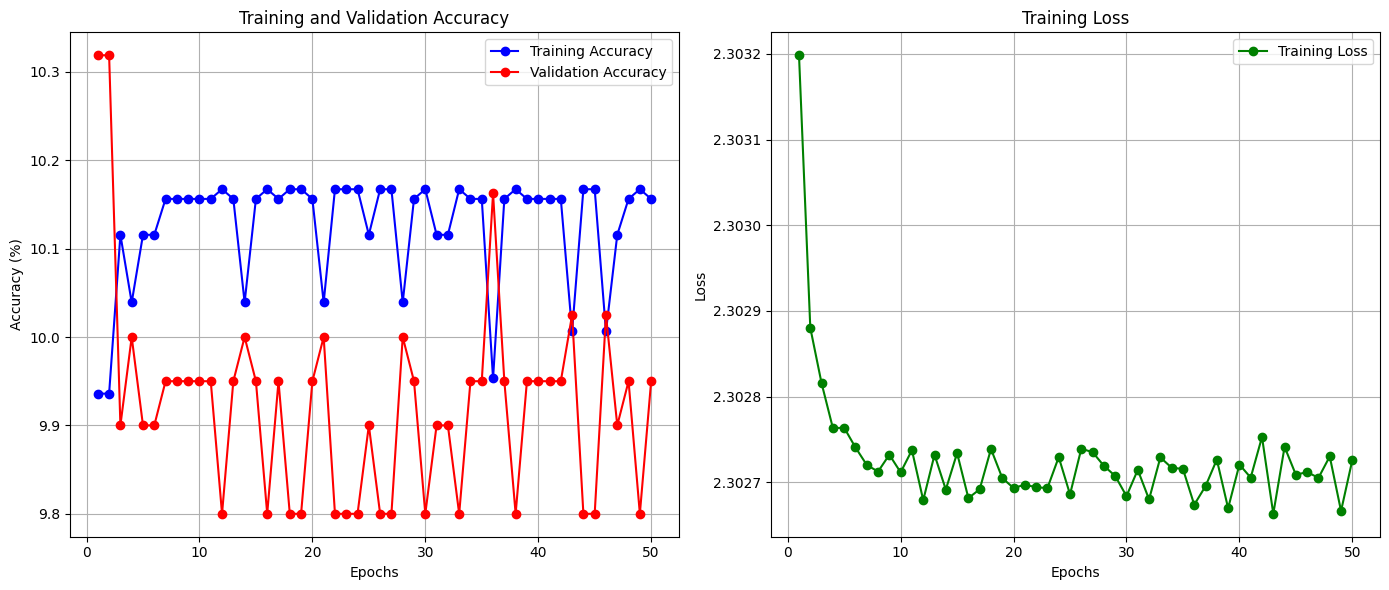

In [ ]:
    
    # --- 1.6. Create a validation split ---
    with Timer(timings, "2. Validation Split"):
        # In a real-world scenario, you would have a separate validation dataset.
        # Here, we split the original training data for demonstration.
        print("\n--- Creating Validation Split ---")
        train_dataset = train_loader.dataset
        val_split = 0.2
        dataset_size = len(train_dataset)
        val_size = int(val_split * dataset_size)
        train_size = dataset_size - val_size
        
        new_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        
        # Create new DataLoaders for the split data
        new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        print(f"Split training data into {len(new_train_dataset)} training samples and {len(val_dataset)} validation samples.")


    # --- 2. Create the CNN model ---
    with Timer(timings, "3. Model Creation"):
        print("\n--- Creating Model ---")
        my_cnn = DynamicCNN(
            input_channels=config['INPUT_CHANNELS'], 
            num_classes=config['NUM_CLASSES'],
            conv_layers_config=conv_config,
            fc_layers_config=fc_config
        )
        
        # Check for multiple GPUs and wrap the model with DataParallel for multi-GPU training
        if torch.cuda.is_available() and torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs for training!")
            my_cnn = nn.DataParallel(my_cnn)

        model_summary_str = str(my_cnn)
        print("Model Architecture:")
        print(model_summary_str)

    # --- 3. Define Loss Function and Optimizer ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(my_cnn.parameters(), lr=config['LEARNING_RATE'])

    # --- 4. Train the model ---
    print("\n--- Training Model ---")
    history, training_time = train_model(
        my_cnn, 
        new_train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=config['NUM_EPOCHS'], 
        device=config['DEVICE']
    )
    timings["4. Model Training"] = training_time


    # --- 5. Plot training results ---
    with Timer(timings, "5. Plotting Results"):
        plot_results(history)

    # --- 6. Test the model on the unseen test set ---
    with Timer(timings, "6. Final Model Testing"):
        print("\n--- Testing Model ---")
        final_test_accuracy = test_model(my_cnn, test_loader, device=config['DEVICE'])

    # --- 7. Save the model ---
    with Timer(timings, "7. Saving Model"):
        print("\n--- Saving Model ---")
        save_model(my_cnn, path=config['MODEL_SAVE_PATH'])

    # --- 8. Load the model ---
    with Timer(timings, "8. Loading Model"):
        print("\n--- Loading Model ---")
        # We need to provide the same configuration to instantiate the model class
        # before loading the saved weights.
        loaded_model = load_model(
            DynamicCNN,
            path=config['MODEL_SAVE_PATH'],
            input_channels=config['INPUT_CHANNELS'],
            num_classes=config['NUM_CLASSES'],
            conv_layers_config=conv_config,
            fc_layers_config=fc_config
        )
        print("Loaded Model Architecture:")
        print(loaded_model)

    # --- 9. Test the loaded model to verify it's working ---
    with Timer(timings, "9. Testing Loaded Model"):
        print("\n--- Testing Loaded Model ---")
        test_model(loaded_model, test_loader, device=config['DEVICE'])
    
    # --- 10. Report Timings ---
    report_timings(timings)
    
    # --- 11. Save Final Report ---
    with Timer(timings, "10. Saving Report"):
        save_report(
            report_path=config['REPORT_SAVE_PATH'],
            config=config,
            model_summary=model_summary_str,
            history=history,
            final_accuracy=final_test_accuracy,
            timings=timings
        )